# Quantify isolation of Baffin Bay interior from Atlantic Water

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import pickle
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.colors import ListedColormap
from math import sin, cos, sqrt, atan2, radians
import xarray as xr
import glob

%matplotlib inline

#### Parameters:

In [4]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179

# Resolution of grid cells to show in figure:
grid_reso  = 10

land_color  = '#a9a7a2'
land_outline_color = '#373736'

# transect coordinates:
BB_coords = (1470,1471,515,670) # Baffin Bay
# DS_coords = (1320,1321,538,630) # Davis Strait (jet)
DS_coords = (1290,1291,502,630) # Davis Strait (jet)

years = [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, \
         2017, 2018, 2019]

month_list = ['Jan.','Feb.','Mar.','Apr.','May','June','July', 'Aug.', 'Sep.','Oct.','Nov.', 'Dec.']

#### Load files:

In [5]:
# Modified ANHA12 mesh mask file (http://knossos.eas.ualberta.ca/anha/anhatable.php)
mfile        = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
mesh_lon     = mfile['nav_lon'].values
mesh_lat     = mfile['nav_lat'].values
mask         = mfile['tmask'].values[0]
mesh_bathy   = mfile['tmask'].values[0,:,:,:]
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
mesh_depth   = mfile['nav_lev'].values

# General file:
mesh  = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
hdept = mesh['hdept'].values[0,:,:]

In [6]:
# transect coordinates
DS_lons  = mesh_lon[DS_coords[0]:DS_coords[1],DS_coords[2]:DS_coords[3]][0,:]
DS_lats  = mesh_lat[DS_coords[0]:DS_coords[1],DS_coords[2]:DS_coords[3]][0,:]
DS_deps  = bathy_masked[:,DS_coords[0]:DS_coords[1],DS_coords[2]:DS_coords[3]][:,0,:]
# DS_depsV = bathy_maskedV[:,DS_coords[0]:DS_coords[1],DS_coords[2]:DS_coords[3]][:,0,:]

#### Functions

In [7]:
def plot_layer(ax, variable, layer, vmin=0, vmax=30, month=''):
    
    x, y = proj1(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax])
    
    CB = proj1.pcolormesh(x, y, variable[layer,:,:]*1e12, cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, ax=ax) 
   
    proj1.contourf(x, y, bathy_masked[layer,imin:imax,jmin:jmax], colors=[land_color], zorder=1, ax=ax) # Mask land at particular depth

    ax.set_title(f'{month}', fontsize=6)
    return CB

In [8]:
# Convert lat/lon to distance along transect:
def calc_distance(lats, lons):
    R = 6373.0 # approximate radius of earth in km

    lats_rad = [radians(l) for l in lats]
    lons_rad = [radians(l) for l in lons]

    dlon = [lon_step - lons_rad[0] for lon_step in lons_rad]
    dlat = [lat_step - lats_rad[0] for lat_step in lats_rad]

    distance = np.empty((len(dlon)))
    for i in range(0,len(dlon)):
        a = sin(dlat[i] / 2)**2 + cos(lats_rad[0]) * cos(lats_rad[i]) * sin(dlon[i] / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance[i] = R * c
        
    return distance

#### Calculations

In [9]:
DS_distance  = calc_distance(DS_lats, DS_lons) 

In [10]:
folder1 = f'/data/brogalla/run_storage/Pb-reference-202303/'
comp1   = xr.open_dataset(f'{folder1}climatology-2007-onwards.nc')
comp2   = xr.open_dataset(f'{folder1}climatology-LS-2007-onwards.nc')
dPb_ref = comp1['dissolpb'].values[:,0,:,:,:]
dPb_LS  = comp2['dissolpb'].values[:,0,:,:,:]

In [11]:
delta_dPb = (dPb_LS - dPb_ref).mean(axis=0) # initially look at mean over full time series, not monthly

In [12]:
# Create masks to isolate Baffin Bay interior and shelf regions

# --- Baffin Bay interior ---
BB_mask  = np.zeros(bathy_masked.shape)
BB_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    BB_mask[depth][mesh_lon < -75]   = 0
    BB_mask[depth][hdept < 1000]     = 0 # isolate by depth=1000 m
    BB_mask[depth][mesh_lat <= 65]   = 0
    BB_mask[depth][mesh_lat > 80]    = 0

BB_mask[mesh_bathy < 0.1] = 0

# --- Baffin Island Shelf ---
BI_mask  = np.zeros(bathy_masked.shape)
BI_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    BI_mask[depth][mesh_lon < -79]   = 0
    BI_mask[depth][mesh_lon > -40]   = 0
    BI_mask[depth][hdept >= 1000]    = 0 # isolate by depth=1000 m
    BI_mask[depth][mesh_lat <= 67]   = 0
    BI_mask[depth][mesh_lat > 73.5]  = 0
    BI_mask[depth][(mesh_lat < 71) & (mesh_lon < -71)]  = 0

    BI_mask[depth][(mesh_lat > 67)   & (mesh_lat < 77) & (mesh_lon > -59.5)]  = 0
    BI_mask[depth][(mesh_lat > 67.4) & (mesh_lat < 72) & (mesh_lon > -60)]  = 0
    BI_mask[depth][(mesh_lat > 68.4) & (mesh_lat < 77) & (mesh_lon > -62)]  = 0
    BI_mask[depth][(mesh_lat > 70)   & (mesh_lat < 77) & (mesh_lon > -65)]  = 0
    BI_mask[depth][(mesh_lat > 73)   & (mesh_lat < 77) & (mesh_lon > -71)]  = 0

BI_mask[mesh_bathy < 0.1] = 0

# --- West Greenland Shelf ---
WG_mask  = np.zeros(bathy_masked.shape)
WG_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    WG_mask[depth][mesh_lon < -69]   = 0
    WG_mask[depth][hdept >= 1000]    = 0 # isolate by depth=1000 m
    WG_mask[depth][mesh_lat <= 67]   = 0
    WG_mask[depth][mesh_lat > 77]    = 0
    WG_mask[depth][(mesh_lat > 64)  & (mesh_lat < 69) & (mesh_lon < -59.8)] = 0
    WG_mask[depth][(mesh_lat > 67)  & (mesh_lat < 73) & (mesh_lon < -64)]   = 0

WG_mask[mesh_bathy < 0.1] = 0

In [13]:
color_GS = '#003856';
color_BB = '#0369a0';
color_BI = '#81b4cf';

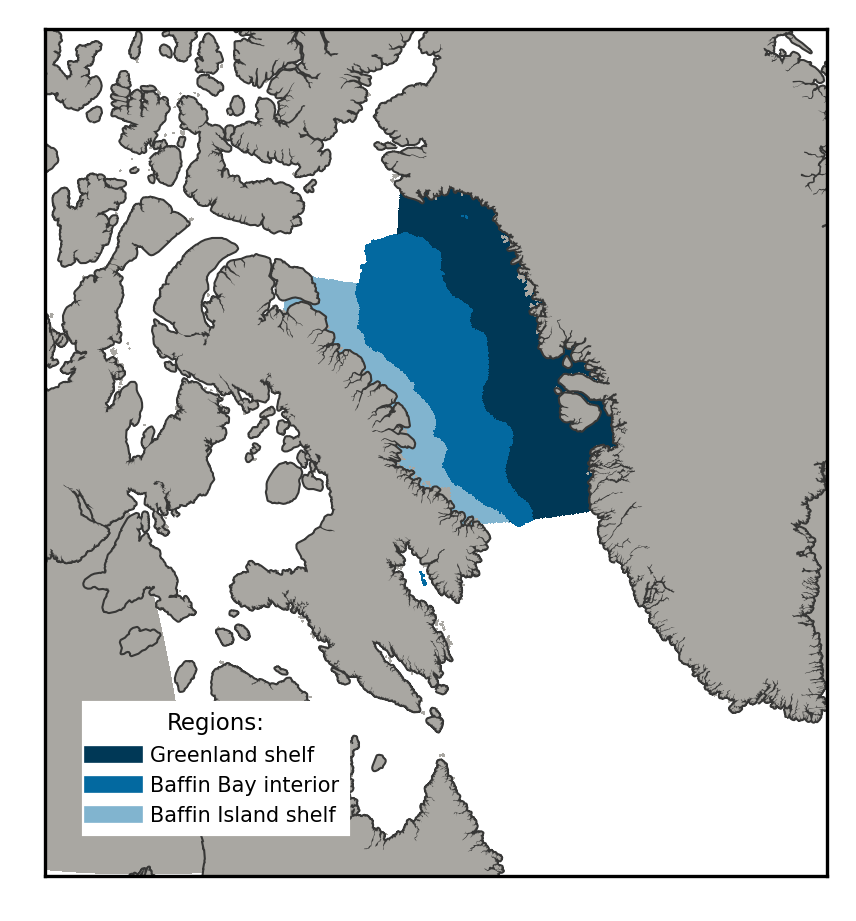

In [39]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/LS.pickle','rb'))

layer=0
x, y = proj1(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax]) 

WG_mask_plot = np.ma.masked_where(WG_mask < 1, WG_mask)
BB_mask_plot = np.ma.masked_where(BB_mask < 1, BB_mask)
BI_mask_plot = np.ma.masked_where(BI_mask < 1, BI_mask)
proj1.pcolormesh(x, y, BI_mask_plot[layer,imin:imax,jmin:jmax] , cmap=ListedColormap([color_BI]))
proj1.pcolormesh(x, y, WG_mask_plot[layer,imin:imax,jmin:jmax], cmap=ListedColormap([color_GS]))
proj1.pcolormesh(x, y, BB_mask_plot[layer,imin:imax,jmin:jmax] , cmap=ListedColormap([color_BB]))
proj1.pcolormesh(x, y, bathy_masked[layer,imin:imax,jmin:jmax], cmap=matplotlib.colors.ListedColormap([land_color]), zorder=1, ax=ax1)
ax1.plot([0,0], [0,0], c=color_GS, lw=4, label='Greenland shelf')
ax1.plot([0,0], [0,0], c=color_BB, lw=4, label='Baffin Bay interior') 
ax1.plot([0,0], [0,0], c=color_BI, lw=4, label='Baffin Island shelf')

leg = ax1.legend(loc=(0.05, 0.05), fontsize=5, facecolor='white', fancybox=False, framealpha=1, edgecolor='white')
leg.set_title('Regions:', prop={'size':5.5})

In [14]:
interior_Atl = np.ma.masked_where(BB_mask[:,imin:imax,jmin:jmax]==0, delta_dPb).mean(axis=(1,2))
Baffin_Atl   = np.ma.masked_where(BI_mask[:,imin:imax,jmin:jmax]==0, delta_dPb).mean(axis=(1,2))
WestGr_Atl   = np.ma.masked_where(WG_mask[:,imin:imax,jmin:jmax]==0, delta_dPb).mean(axis=(1,2))
ratio_interior_Baffin_Atl = interior_Atl/Baffin_Atl;  
ratio_interior_WestGr_Atl = interior_Atl/WestGr_Atl;  
ratio_Baffin_WestGr_Atl   = Baffin_Atl/WestGr_Atl;

In [15]:
interior_dPb = np.ma.masked_where(BB_mask[:,imin:imax,jmin:jmax]==0, dPb_ref.mean(axis=0)).mean(axis=(1,2))
Baffin_dPb   = np.ma.masked_where(BI_mask[:,imin:imax,jmin:jmax]==0, dPb_ref.mean(axis=0)).mean(axis=(1,2))
WestGr_dPb   = np.ma.masked_where(WG_mask[:,imin:imax,jmin:jmax]==0, dPb_ref.mean(axis=0)).mean(axis=(1,2))
ratio_interior_Baffin_dPb = interior_dPb/Baffin_dPb;  
ratio_interior_WestGr_dPb = interior_dPb/WestGr_dPb;  
ratio_Baffin_WestGr_dPb   = Baffin_dPb/WestGr_dPb;

#### Figure:

Text(0.5, 0, '$\\Delta$ Dissolved Pb (pM)')

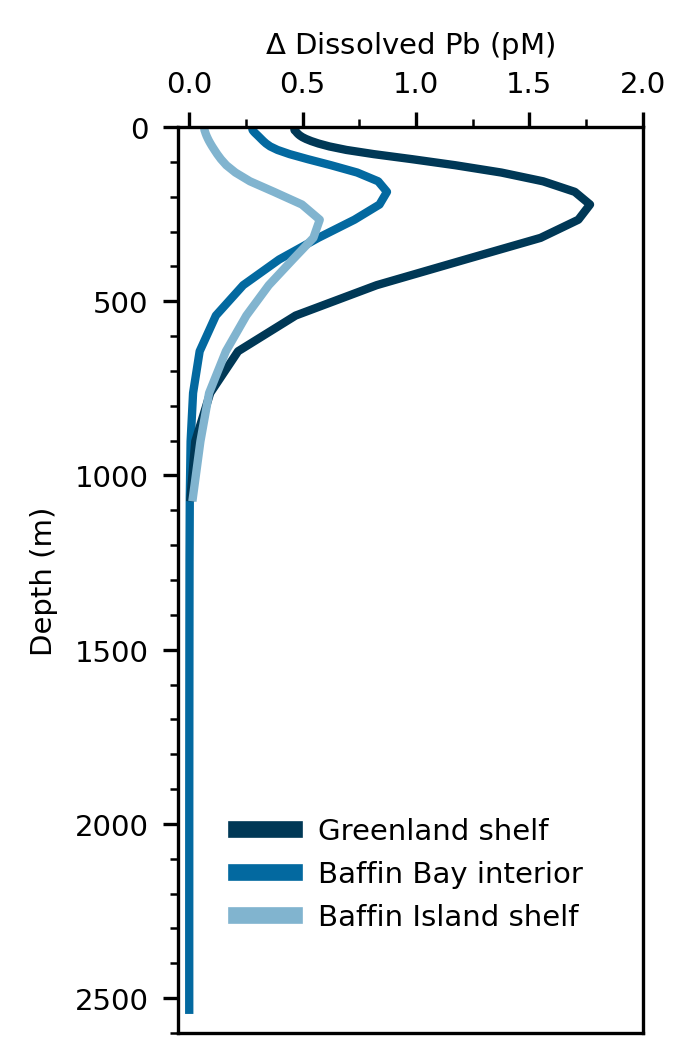

In [17]:
fig, ax = plt.subplots(1,1, figsize=(2, 4), dpi=300)

ax.plot(interior_Atl*1e12, mesh_depth, '-', c=color_BB, lw=2.0, markersize=6)
ax.plot(WestGr_Atl*1e12, mesh_depth, '-', c=color_GS, lw=2.0, markersize=6)
ax.plot(Baffin_Atl*1e12, mesh_depth, '-', c=color_BI, lw=2.0, markersize=6)

ax.plot([0,0], [0,0], c=color_GS, lw=4, label='Greenland shelf')
ax.plot([0,0], [0,0], c=color_BB, lw=4, label='Baffin Bay interior') 
ax.plot([0,0], [0,0], c=color_BI, lw=4, label='Baffin Island shelf')

ax.yaxis.set_minor_locator(MultipleLocator(100))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.set_ylim(2600,0)
ax.set_xlim(-0.05,2.0)
ax.xaxis.tick_top()
ax.legend(loc=(0.1, 0.1), fontsize=7, frameon=False)
ax.xaxis.set_label_position('top') 
ax.set_ylabel('Depth (m)', fontsize=7)
ax.tick_params(axis='both', labelsize=7)
ax.set_xlabel(r'$\Delta$ Dissolved Pb (pM)', fontsize=7)

In [15]:
monthly_BB_mask = np.tile(BB_mask[:,imin:imax,jmin:jmax], (12,1,1,1))

In [17]:
dPb_BB_interior = np.ma.masked_where(monthly_BB_mask==0, dPb_ref).mean(axis=(1,2,3))
Atl_BB_interior = np.ma.masked_where(monthly_BB_mask==0, dPb_LS - dPb_ref).mean(axis=(1,2,3))
# dPb_BB_interior_2014 = np.ma.masked_where(monthly_BB_mask==0, dPb_2014).mean(axis=(1,2,3))

In [16]:
dPb_interannual_ref = np.empty((len(years),12))
dPb_interannual_Atl = np.empty((len(years),12))
for y, year in enumerate(years):
    print(year)
    for mth in range(1,13):
        folder1 = f'/data/brogalla/run_storage/Pb-reference-202303/Pb-reference-{year}_20230308/'
        folder2 = f'/data/brogalla/run_storage/Pb-reference-202303/Pb-Labrador-Sea-{year}_20230308/'
        comp1   = xr.open_dataset(f'{folder1}ANHA12_EXH006_1m_{year}0101_{year}1231_comp_{year}{mth:02}-{year}{mth:02}.nc')
        comp2   = xr.open_dataset(f'{folder2}ANHA12_EXH006_1m_{year}0101_{year}1231_comp_{year}{mth:02}-{year}{mth:02}.nc')
        
        dPb_interannual_ref[y, mth-1] = np.ma.masked_where(BB_mask[:,imin:imax,jmin:jmax]==0, \
                                                           comp1['dissolpb'].values[0,:,:,:]).mean(axis=(0,1,2))
        dPb_interannual_Atl[y, mth-1] = np.ma.masked_where(BB_mask[:,imin:imax,jmin:jmax]==0, \
                                                           comp2['dissolpb'].values[0,:,:,:]- \
                                                           comp1['dissolpb'].values[0,:,:,:]).mean(axis=(0,1,2))

2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


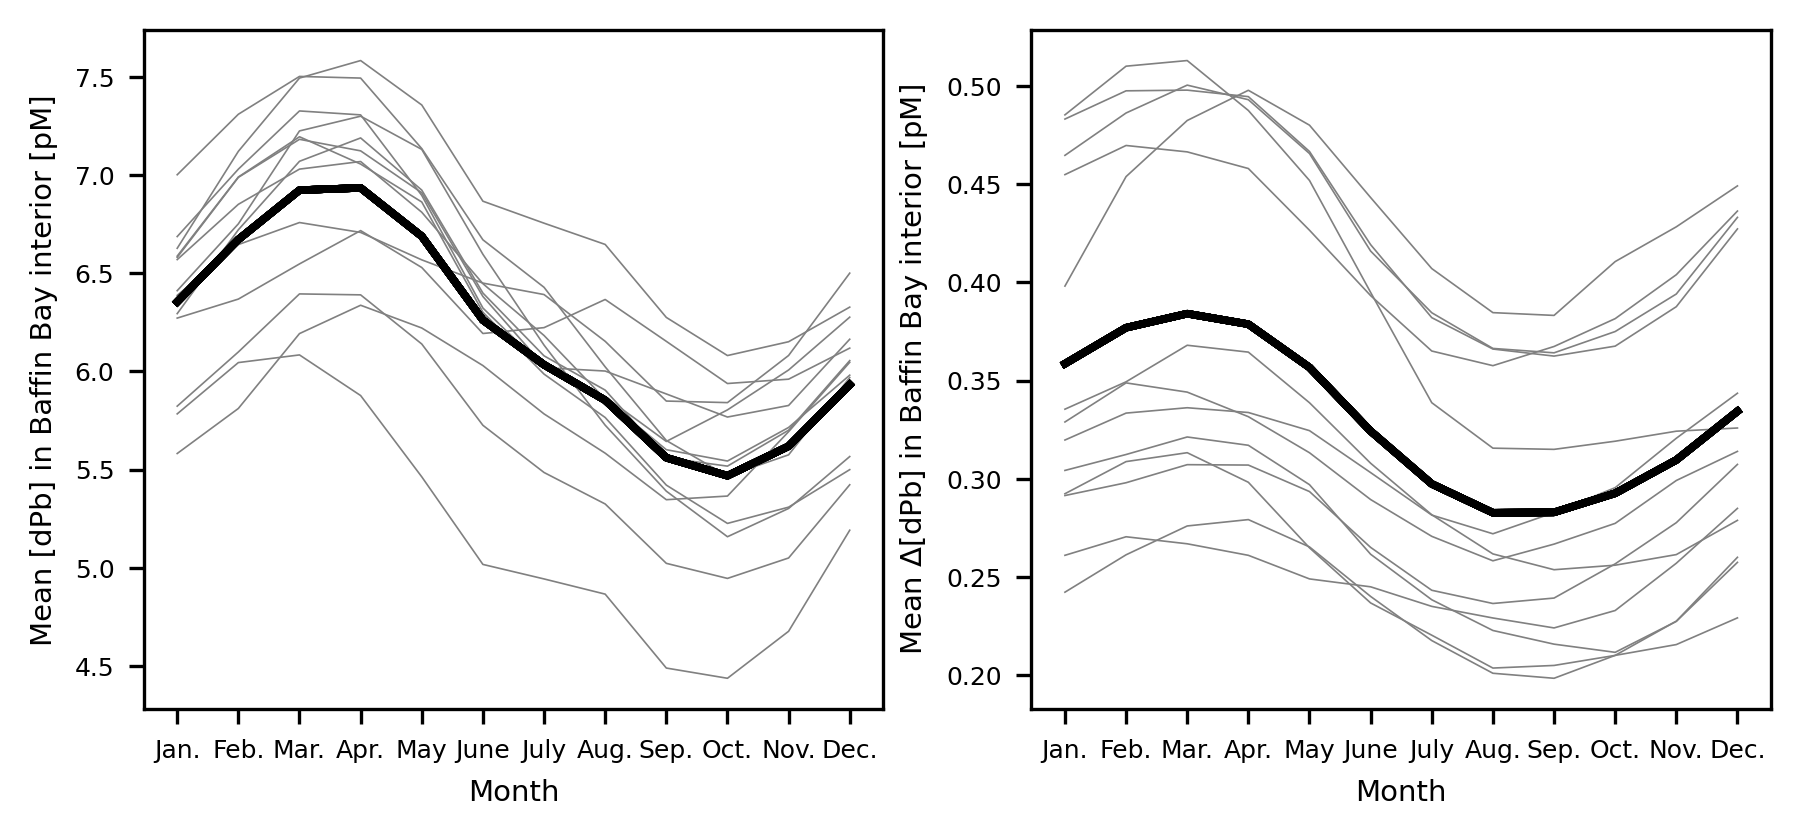

In [173]:
fig, ax = plt.subplots(1,2, figsize=(7,3), dpi=300)
for axis in ax.ravel():
    axis.set_xlabel('Month', fontsize=7)
    axis.tick_params(axis='both', which='major', labelsize=6)

ax[0].set_ylabel(r'Mean [dPb] in Baffin Bay interior [pM]', fontsize=7)
ax[1].set_ylabel(r'Mean $\Delta$[dPb] in Baffin Bay interior [pM]', fontsize=7)

for y, year in enumerate(years):
    if y > 4:
        ax[0].plot(month_list, dPb_interannual_ref[y,:]*1e12, 'gray', lw=0.4)
        ax[0].plot(month_list, dPb_interannual_ref[5:].mean(axis=0)*1e12, 'k', lw=1.8)
        ax[1].plot(month_list, dPb_interannual_Atl[y,:]*1e12, 'gray', lw=0.4)
        ax[1].plot(month_list, dPb_interannual_Atl[5:].mean(axis=0)*1e12, 'k', lw=1.8)
    
    # compare with Pacini et al. 2020

In [18]:
layer = 28
month = 10
vmin  = 0; vmax = 3;

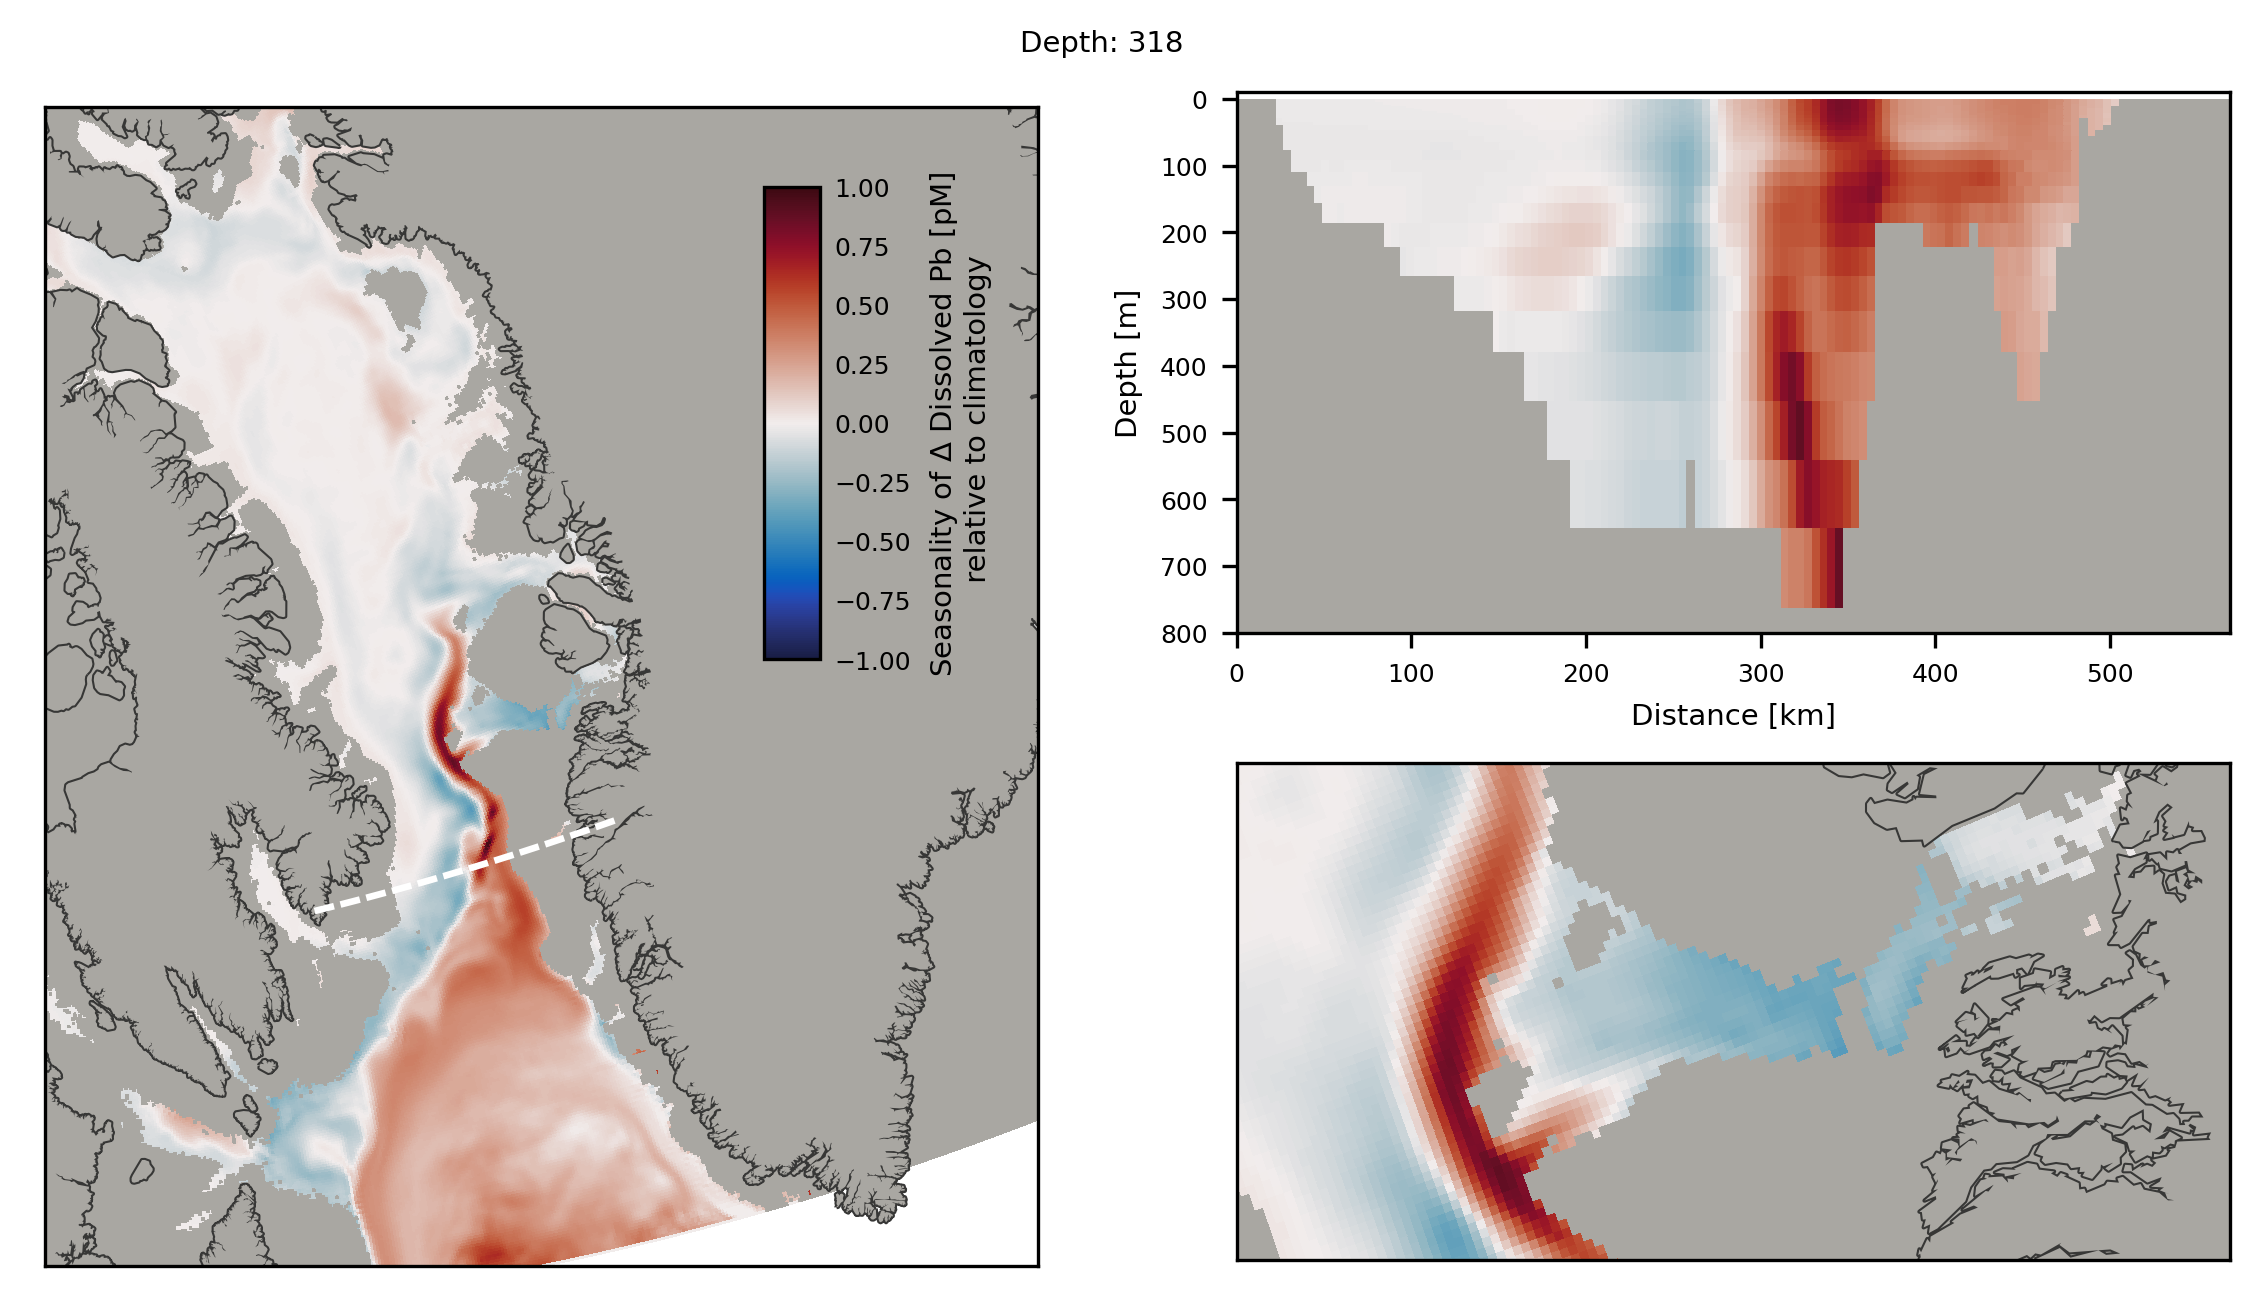

In [19]:
fig = plt.figure(figsize=(4.7*2,3.5*1.5), dpi=300)
gs  = fig.add_gridspec(2,2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

fig.suptitle(f'Depth: {mesh_depth[layer]:.0f}', fontsize=7, y=0.92)

# -------------------- top left ----------------------
proj1=Basemap(projection='eqdc',lat_0 = 69, lon_0 = -55, resolution='i', width=1.8e6, height=2.1e6, ax=ax1)
proj1.drawcoastlines(color=land_outline_color, linewidth=1.0);
proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=2);

x, y = proj1(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax])
# CB = proj1.pcolormesh(x, y, (dPb_LS[month-1,layer,:,:]-dPb_ref[month-1,layer,:,:])*1e12, \
#                       cmap=cmocean.cm.rain, vmin=vmin, vmax=vmax, ax=ax1) 
CB = proj1.pcolormesh(x, y, ((dPb_LS[month,layer,:,:]-dPb_ref[month,layer,:,:]) - \
                      (dPb_LS[:,layer,:,:]-dPb_ref[:,layer,:,:]).mean(axis=0))*1e12, \
                      cmap=cmocean.cm.balance, vmin=-1, vmax=1, ax=ax1) 
proj1.pcolormesh(x, y, bathy_masked[layer,imin:imax,jmin:jmax], \
               cmap=matplotlib.colors.ListedColormap([land_color]), zorder=1, ax=ax1)

ax1.plot(x[DS_coords[0]-imin,DS_coords[2]-jmin:DS_coords[3]-jmin], 
         y[DS_coords[0]-imin,DS_coords[2]-jmin:DS_coords[3]-jmin], 'w', linestyle=(0, (3, 1)), lw=1.6, zorder=4)

# --------------------- top right --------------------
ref = dPb_ref[month,:,DS_coords[0]-imin:DS_coords[1]-imin,DS_coords[2]-jmin:DS_coords[3]-jmin][:,0,:]
LS  = dPb_LS[month,:,DS_coords[0]-imin:DS_coords[1]-imin,DS_coords[2]-jmin:DS_coords[3]-jmin][:,0,:]
ref_mean = dPb_ref[:,:,DS_coords[0]-imin:DS_coords[1]-imin,DS_coords[2]-jmin:DS_coords[3]-jmin].mean(axis=0)[:,0,:]
LS_mean  = dPb_LS[:,:,DS_coords[0]-imin:DS_coords[1]-imin,DS_coords[2]-jmin:DS_coords[3]-jmin].mean(axis=0)[:,0,:]
        
ax2.set_xlabel('Distance [km]', fontsize=7)
ax2.set_ylabel('Depth [m]', fontsize=7)
ax2.invert_yaxis()
ax2.tick_params(axis='both', which='major', labelsize=6)
ax2.set_ylim(800,-10)

# Cross-section
xx, zz = np.meshgrid(DS_distance, mesh_depth)
# CB1 = ax2.pcolormesh(xx, zz, (LS-ref)*1e12, vmin=vmin, vmax=vmax, cmap=cmocean.cm.rain)
CB1 = ax2.pcolormesh(xx, zz, ((LS-ref)-(LS_mean-ref_mean))*1e12, vmin=-1, vmax=1, cmap=cmocean.cm.balance)
ax2.pcolormesh(xx, zz, DS_deps, cmap=matplotlib.colors.ListedColormap([land_color]))

# --------------------- bottom right --------------------
proj2=Basemap(projection='eqdc',lat_0 = 68.5, lon_0 = -56, resolution='i', width=0.5e6, height=0.25e6, ax=ax3)
proj2.drawcoastlines(color=land_outline_color, linewidth=1.0);
proj2.fillcontinents(color=land_color, lake_color=land_color, zorder=2);
x, y = proj2(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax])
# CB = proj2.pcolormesh(x, y, (dPb_LS[month-1,layer,:,:]-dPb_ref[month-1,layer,:,:])*1e12, \
#                       cmap=cmocean.cm.rain, vmin=vmin, vmax=vmax, ax=ax3) 
CB = proj2.pcolormesh(x, y, ((dPb_LS[month,layer,:,:]-dPb_ref[month,layer,:,:]) - \
                      (dPb_LS[:,layer,:,:]-dPb_ref[:,layer,:,:]).mean(axis=0))*1e12, \
                      cmap=cmocean.cm.balance, vmin=-1, vmax=1, ax=ax3) 
proj2.pcolormesh(x, y, bathy_masked[layer,imin:imax,jmin:jmax], \
               cmap=matplotlib.colors.ListedColormap([land_color]), zorder=1, ax=ax3)


cbax1 = fig.add_axes([0.38, 0.52, 0.02, 0.3]);
CBar  = plt.colorbar(CB1, ax=ax2, cax=cbax1);#, ticks=[0,1,2,3]); 
CBar.set_label(r"Seasonality of $\Delta$ Dissolved Pb [pM]"+'\n relative to climatology', fontsize=7)
CBar.ax.tick_params(axis='y', length=0, labelsize=6)

In [21]:
layer = 30

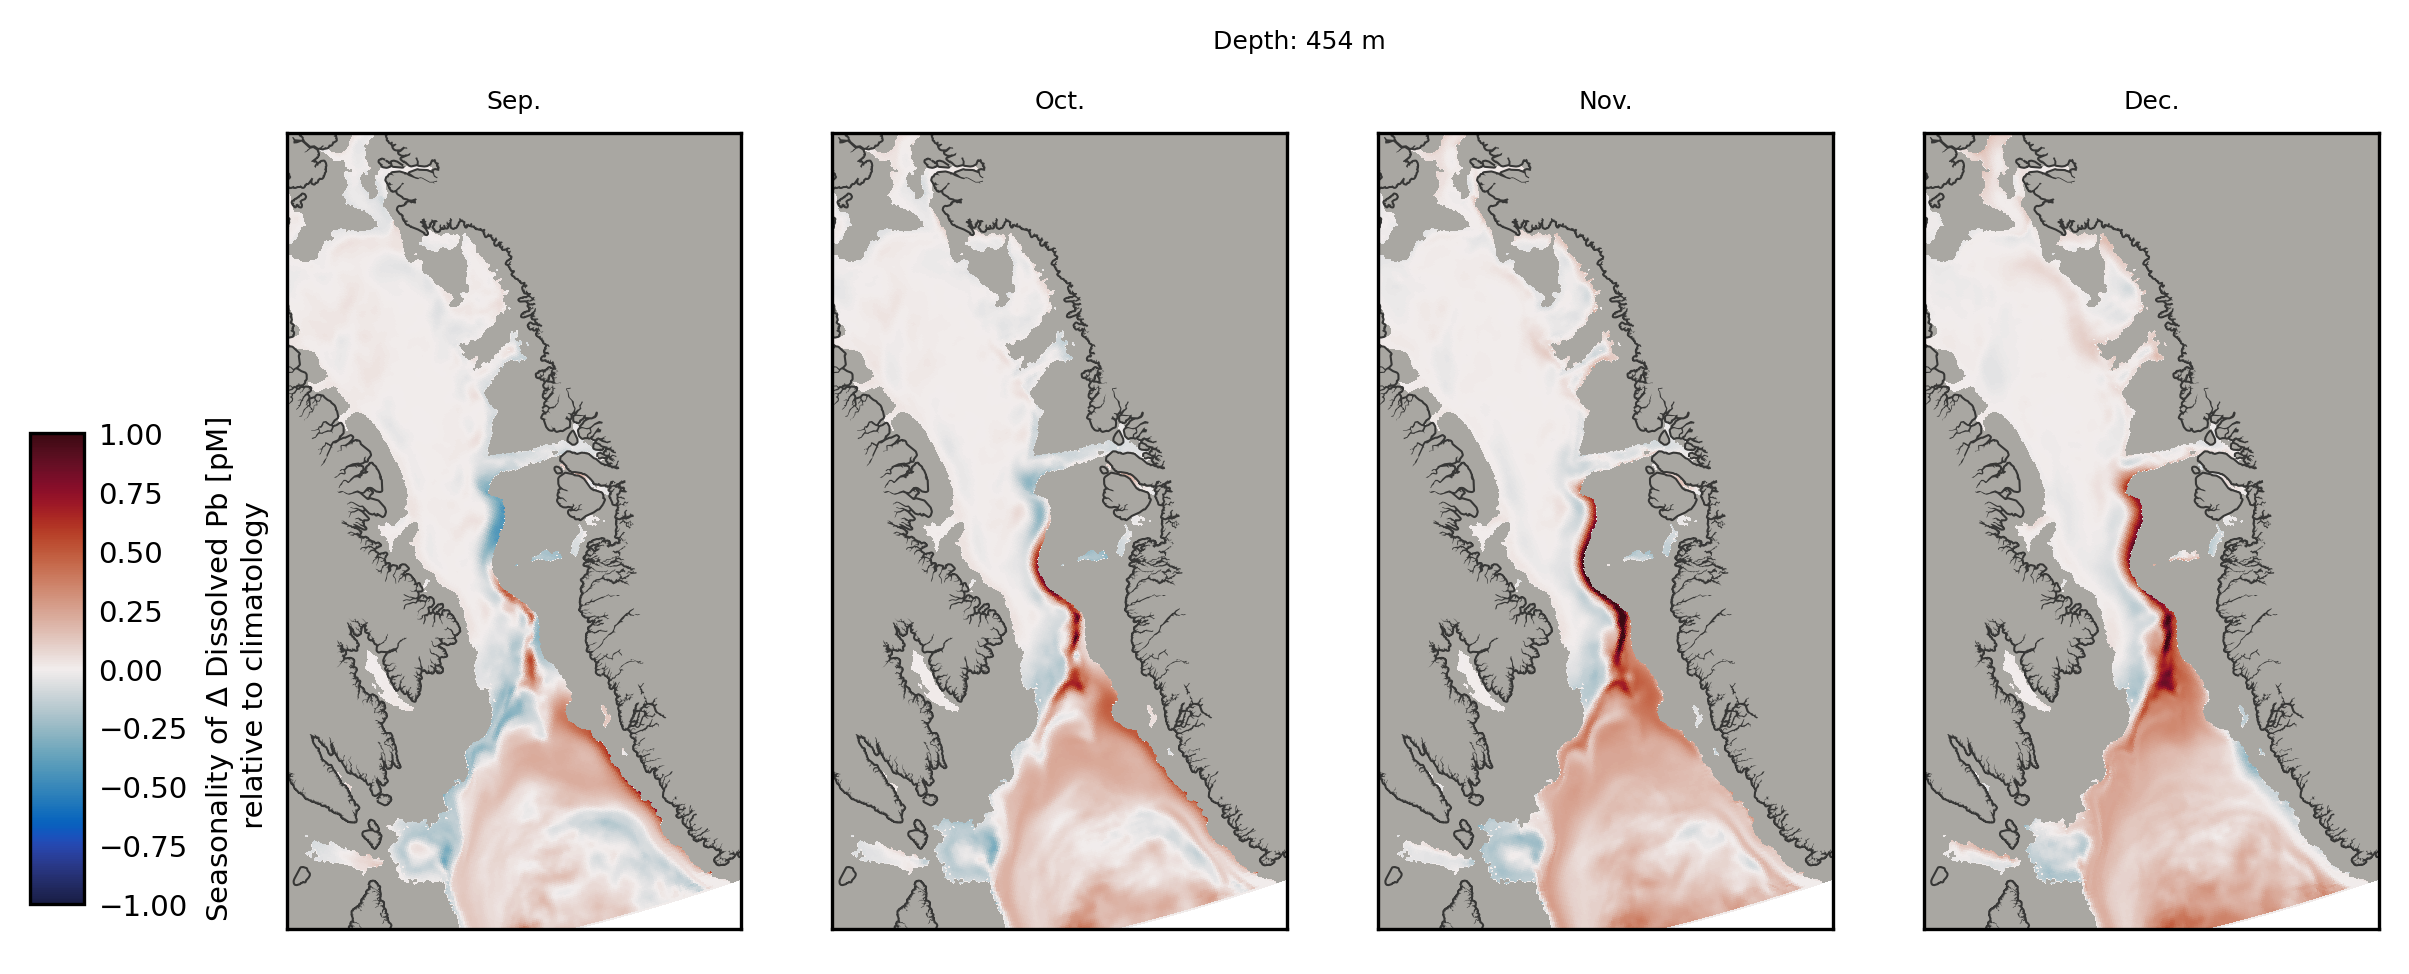

In [22]:
fig, ax, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/Pb4.pickle','rb'))
x, y = proj1(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax]) 

for n, mth in enumerate(range(9,13)):
    CB = plot_layer(ax.ravel()[n], (dPb_LS[mth-1]-dPb_ref[mth-1]) - (dPb_LS-dPb_ref).mean(axis=0), layer, 
                    vmin=-1, vmax=1, month=month_list[mth-1])
  
fig.suptitle(f'Depth: {mesh_depth[layer]:.0f} m', fontsize=6, y=0.95)

# Color bar: --------------------------------------------------------------------------------
cbaxes = fig.add_axes([0.03, 0.17, 0.02, 0.42]);
CBar   = plt.colorbar(CB, cax=cbaxes); 
CBar.set_label(r"Seasonality of $\Delta$ Dissolved Pb [pM]"+'\n relative to climatology', fontsize=7)
CBar.ax.tick_params(axis='y', length=0, labelsize=7)

In [52]:
layer = 15

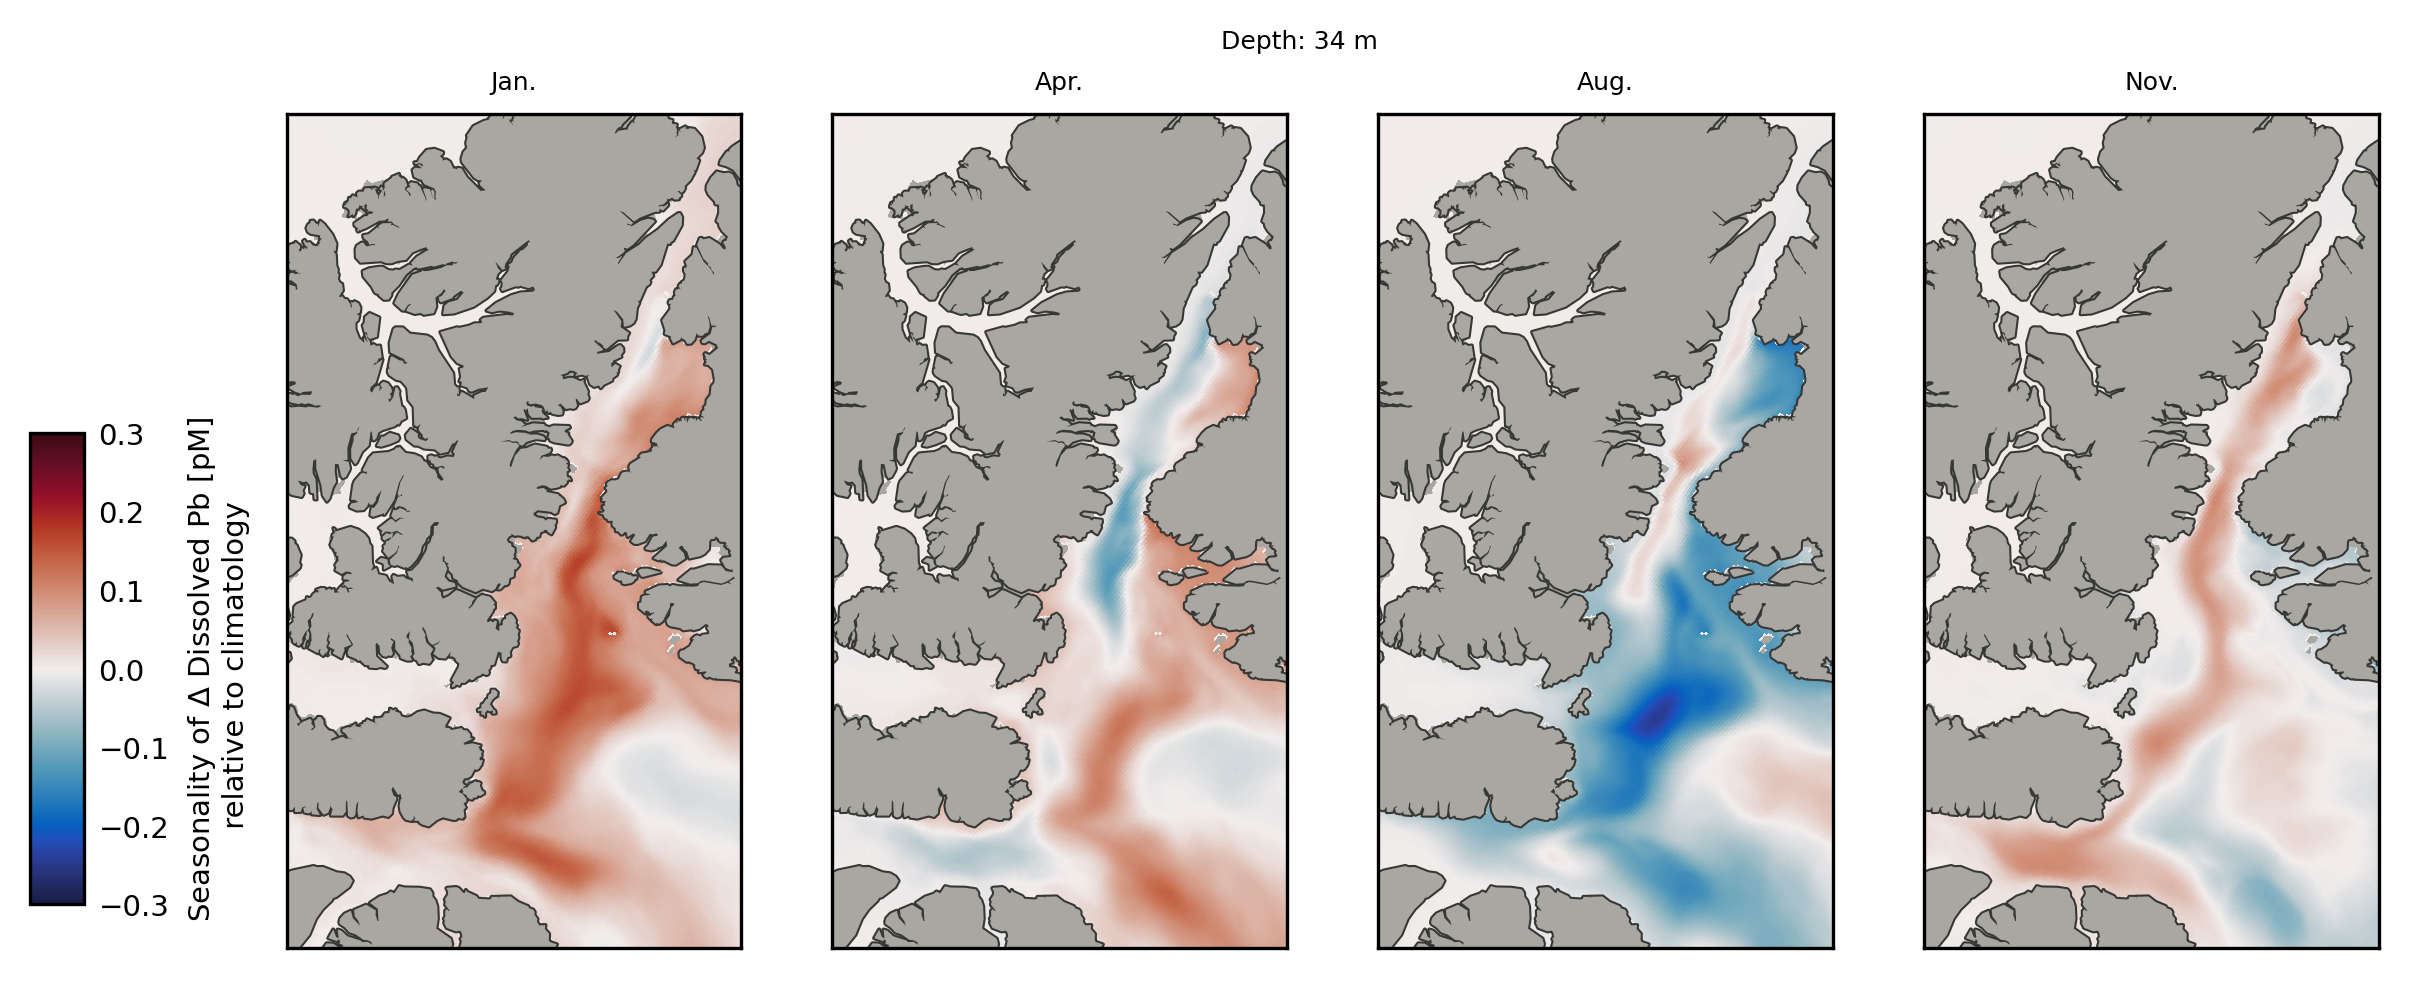

In [55]:
fig, ax, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/Nares4.pickle','rb'))
x, y = proj1(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax]) 

for n, mth in enumerate([1,4,8,11]):
    CB = plot_layer(ax.ravel()[n], (dPb_LS[mth-1]-dPb_ref[mth-1]) - (dPb_LS-dPb_ref).mean(axis=0), layer, 
                    vmin=-0.3, vmax=0.3, month=month_list[mth-1])
  
fig.suptitle(f'Depth: {mesh_depth[layer]:.0f} m', fontsize=6, y=0.95)

# Color bar: --------------------------------------------------------------------------------
cbaxes = fig.add_axes([0.03, 0.17, 0.02, 0.42]);
CBar   = plt.colorbar(CB, cax=cbaxes); 
CBar.set_label(r"Seasonality of $\Delta$ Dissolved Pb [pM]"+'\n relative to climatology', fontsize=7)
CBar.ax.tick_params(axis='y', length=0, labelsize=7)

In [48]:
layer = 28

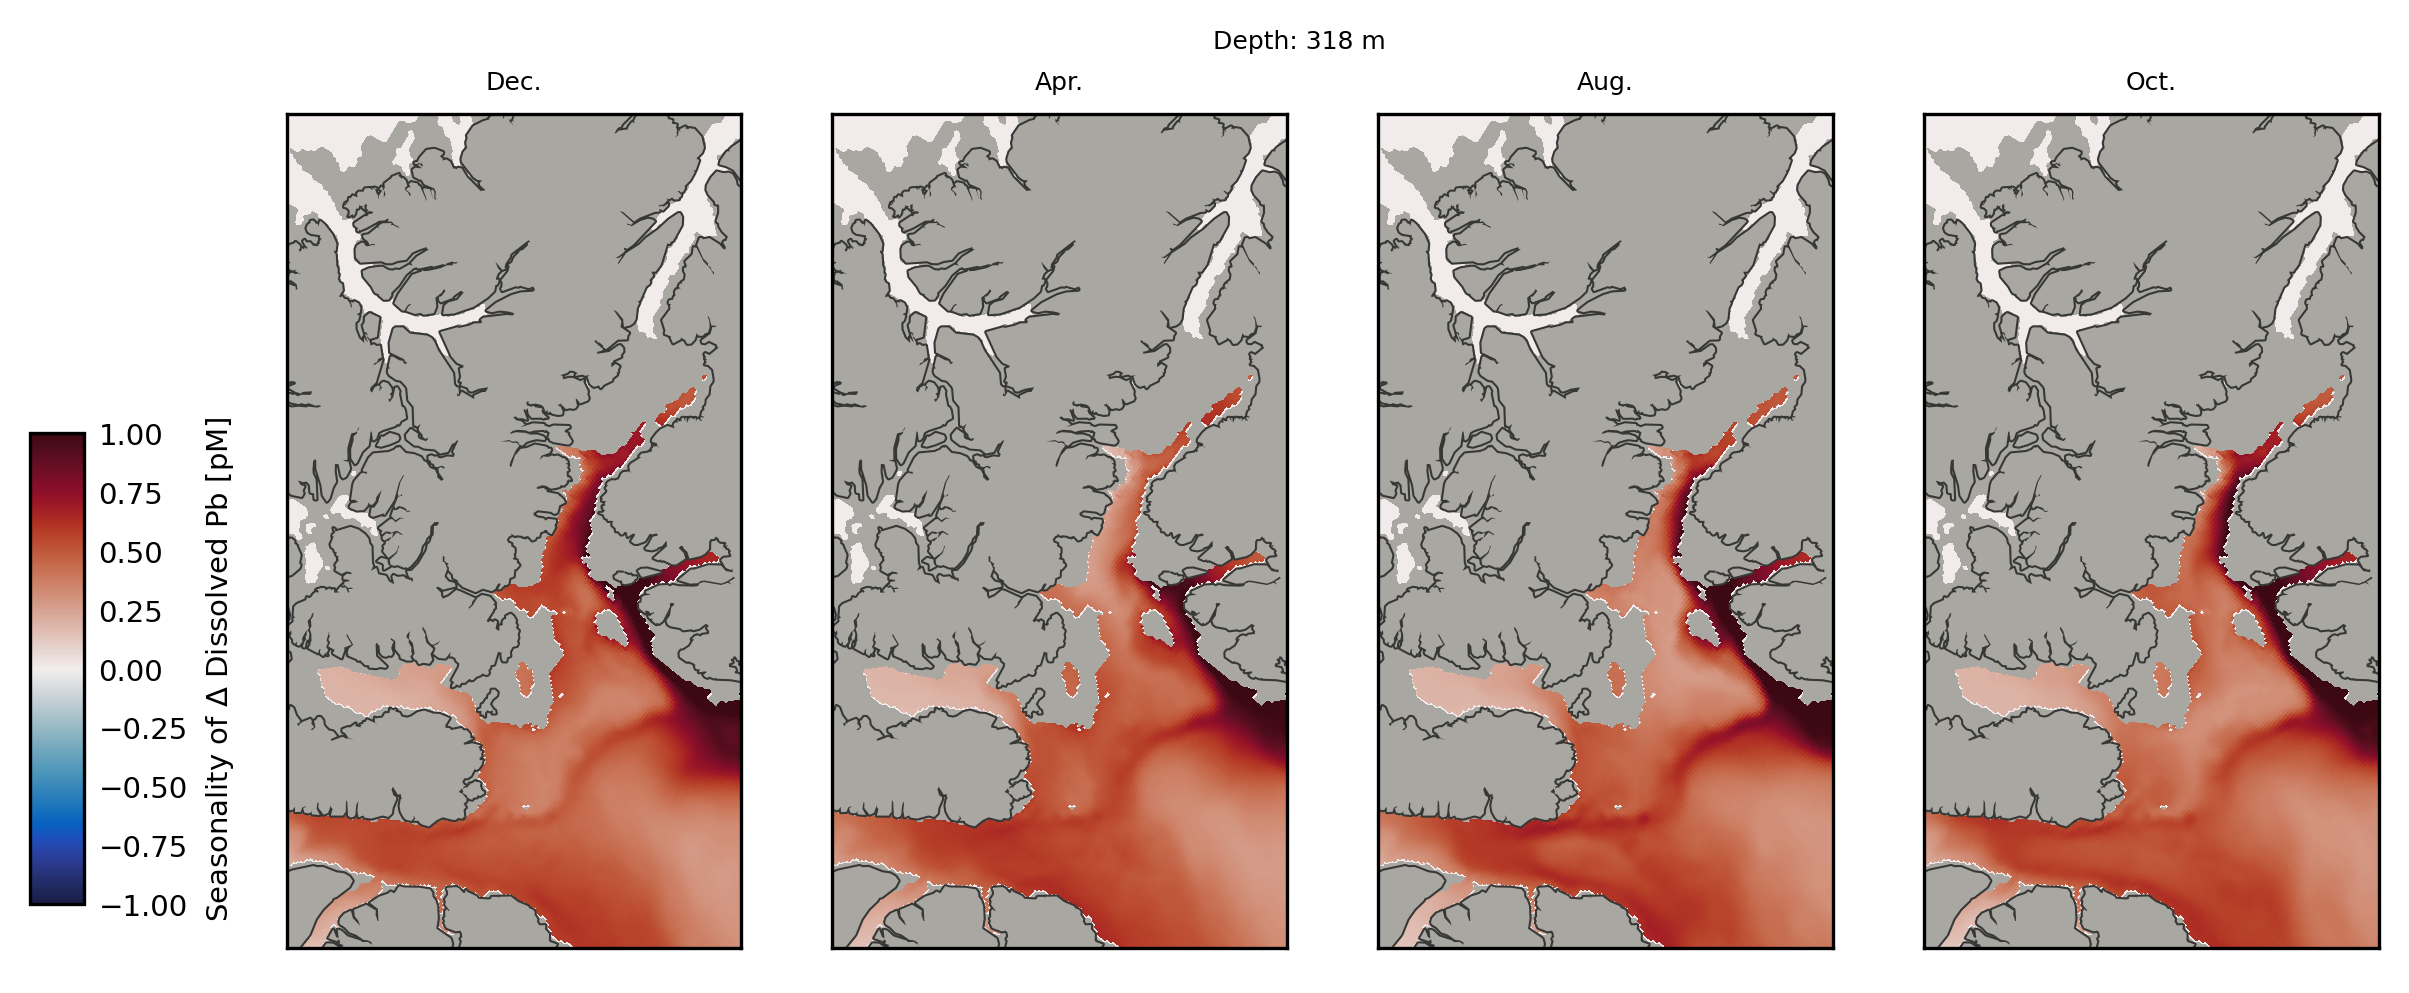

In [49]:
fig, ax, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/Nares4.pickle','rb'))
x, y = proj1(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax]) 

for n, mth in enumerate([0,4,8,10]):
    CB = plot_layer(ax.ravel()[n], (dPb_LS[mth-1]-dPb_ref[mth-1]), layer, 
                    vmin=-1, vmax=1, month=month_list[mth-1])
  
fig.suptitle(f'Depth: {mesh_depth[layer]:.0f} m', fontsize=6, y=0.95)

# Color bar: --------------------------------------------------------------------------------
cbaxes = fig.add_axes([0.03, 0.17, 0.02, 0.42]);
CBar   = plt.colorbar(CB, cax=cbaxes); 
CBar.set_label(r"Seasonality of $\Delta$ Dissolved Pb [pM]", fontsize=7)
CBar.ax.tick_params(axis='y', length=0, labelsize=7)